In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment
from src.runner import runner
from src.helpers import confidence_interval, what_informality
import pickle
from sklearn import preprocessing
import random
import json
import datetime

In [2]:
style.use('seaborn-white')

### 1 load general the parameters

In [3]:
with open('parameters/parameters.json') as json_file:
    parameters = json.load(json_file)

parameters['data_output'] = 'csv_light'
parameters['number_of_agents'] = 100000

In [6]:
initial_agents = max(round((310 / (3740026 / parameters['number_of_agents']) * 100/14)), 20) # 310 cases / (population / agent) * 1 / 14% detected cases
initial_agents

59

In [146]:
parameters['informality_dummy'] = 1.0
parameters['lockdown_days'] = [x for x in range(0, parameters['time'])]
#parameters['probability_transmission'] = 0.5
parameters['total_initial_infections'] = [x for x in range(initial_agents)]

In [147]:
parameters

{'time': 120,
 'number_of_agents': 100000,
 'monte_carlo_runs': 1,
 'exposed_days': 4,
 'asymptom_days': 10,
 'symptom_days': 10,
 'critical_days': 8,
 'probability_symptomatic': 0.6165,
 'no_hospital_multiplier': 1.79,
 'probability_transmission': 0.00335,
 'probability_critical': {'age_0_10': 0.001,
  'age_10_20': 0.003,
  'age_20_30': 0.012,
  'age_30_40': 0.032,
  'age_40_50': 0.049,
  'age_50_60': 0.102,
  'age_60_70': 0.166,
  'age_70_80': 0.244,
  'age_80_plus': 0.273},
 'probability_to_die': {'age_0_10': 0.005,
  'age_10_20': 0.021,
  'age_20_30': 0.053,
  'age_30_40': 0.126,
  'age_40_50': 0.221,
  'age_50_60': 0.303,
  'age_60_70': 0.565,
  'age_70_80': 0.653,
  'age_80_plus': 0.765},
 'total_initial_infections': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  

In [148]:
parameters['probability_transmission']

0.00335

### 2 load neighbourhood data

In [149]:
with open('parameters/district_data_100k.json') as json_file:
    neighbourhood_data = json.load(json_file)

### 2 initialization from pickle

In [150]:
data = open('seed_22_forjoeri.pkl', "rb")
list_of_objects = pickle.load(data)
environment = list_of_objects[0]

In [151]:
# correct time
environment.parameters['time'] = parameters['time']

# correct informality
if parameters["informality_dummy"] == 1.0:
    for agent in environment.agents:
        agent.informality = what_informality(agent.district, neighbourhood_data) * parameters["informality_dummy"]

environment.parameters['probability_transmission']= parameters['probability_transmission']#!!!!###!!!###
environment.parameters['number_of_agents'] = 100000 #!!!!###!!!###
environment.parameters['data_output']=parameters['data_output']#!!!!###!!!###
environment.parameters["total_initial_infections"]=parameters["total_initial_infections"]
environment.parameters['informality_dummy']=parameters["informality_dummy"] 
environment.parameters["lockdown_days"]  = parameters["lockdown_days"] 
environment.parameters["health_system_capacity"] =parameters["health_system_capacity"]
environment.parameters['total_initial_infections'] = parameters['total_initial_infections']

### Experiment with policy parameters

In [152]:
environment.parameters["physical_distancing_multiplier"] = 0.9# 0.51
environment.parameters["visiting_recurring_contacts_multiplier"] = 0.45983870967741947
environment.parameters["likelihood_awareness"] = 0.54 # 0.54
environment.parameters["gathering_max_contacts"] = 24# 12

In [153]:
data_folder = 'measurement/baseline_100k/'
seed = 22

# Simulate model

In [154]:
environment = runner(environment, 0, data_folder=data_folder, data_output=environment.parameters['data_output'])

3


In [156]:
if parameters["data_output"] == 'csv_light':
    pd.DataFrame(environment.infection_quantities).to_csv('{}seed{}/quantities_state_time_0.csv'.format(data_folder,
                                                                                                      seed))

# Analyse

In [141]:
data_formal = pd.read_csv('{}seed{}/quantities_state_time.csv'.format(data_folder, seed), index_col=0)

In [157]:
data_informal = pd.read_csv('{}seed{}/quantities_state_time_0.csv'.format(data_folder, seed), index_col=0)

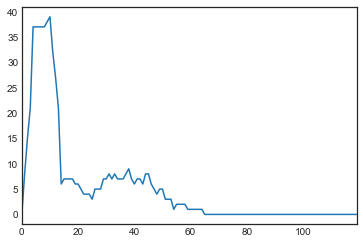

In [176]:
data_formal['i2'].plot()
#data_formal['d'].plot()

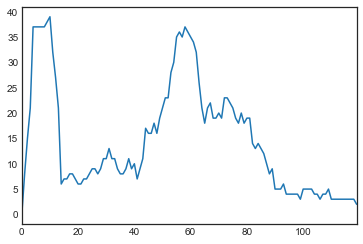

In [177]:
data_informal['i2'].plot()

In [170]:
start_date = datetime.datetime(2020, 3, 29)
dates = [start_date + datetime.timedelta(days=x) for x in data_formal.index]
#dates

Text(0.5, 0, 'Date')

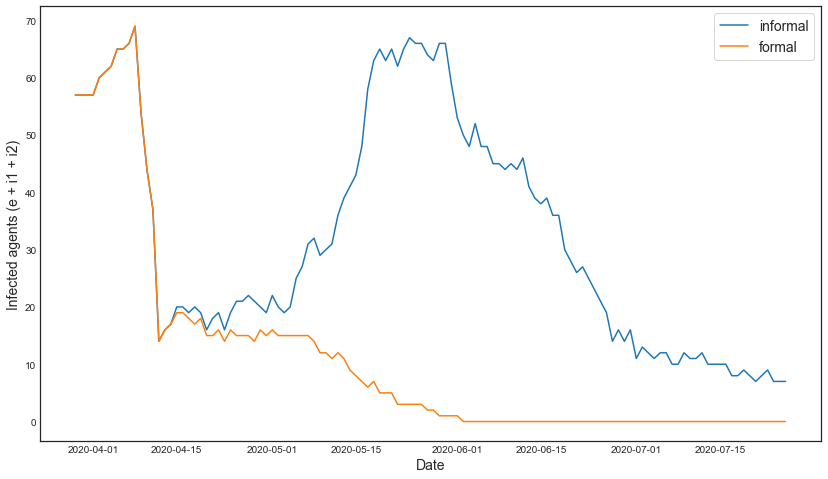

In [175]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(dates, data_informal['e'] + data_informal['i1'] + data_informal['i2'], label='informal')
ax.plot(dates, data_formal['e']  + data_formal['i1'] + data_formal['i2'], label='formal')

ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Infected agents (e + i1 + i2)', fontsize='14')
ax.set_xlabel('Date', fontsize='14')

Text(0.5, 0, 'Days')

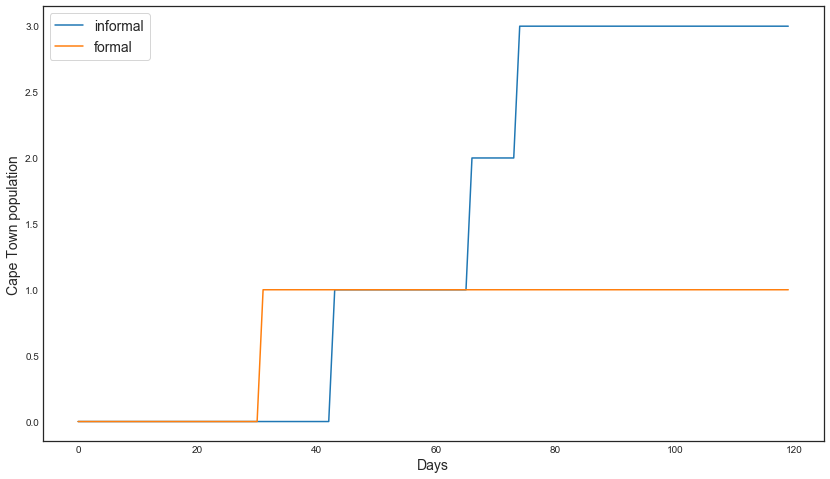

In [95]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(data_informal.index, data_informal['d'], label='informal')
ax.plot(data_formal.index, data_formal['d'], label='formal')

ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')